# Compare predicted netrex+ network with gold standard yeast

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

In [2]:
#gold = pd.read_table('goldstd_idx_for_comparison', header=1, index_col=0)
#predicted = pd.read_table('predicted_idx_for_comparison', index_col=0)

#print(gold.shape, predicted.shape)

In [3]:
#import gold standard networks and add all together

gold1 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/MacIsaac2.KO.txt', header=None, names=['regulator','gene'])
gold2 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/MacIsaac2.NatVar.txt', header=None, names=['regulator','gene'])
gold3 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/MacIsaac2.Stress.txt', header=None, names=['regulator','gene'])
gold4 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Count3.KO.txt', header=None, names=['regulator','gene'])
gold5 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Count3.NatVar.txt', header=None, names=['regulator','gene'])
gold6 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Count3.Stress.txt', header=None, names=['regulator','gene'])                      
gold7 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Type2.KO.txt', header=None, names=['regulator','gene'])                      
gold8 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Type2.NatVar.txt', header=None, names=['regulator','gene'])
gold9 = pd.read_table('../../s2cell-prior/data/yeast_networks/gold/YEASTRACT_Type2.Stress.txt', header=None, names=['regulator','gene'])

goldstd = pd.concat([gold1, gold2, gold3, gold4, gold5, gold6, gold7, gold8, gold9])
goldstd.drop_duplicates(inplace=True)

goldstd['weight'] = 1.0
gold = goldstd.set_index(['gene','regulator']).unstack().fillna(value=0)

In [4]:
#remove names
gold.columns = gold.columns.get_level_values(1)
gold.index.name = None
gold.columns.name = None

gold.head()

,YAL051W,YBL005W,YBL021C,YBL103C,YBR049C,YBR066C,YBR083W,YBR182C,YBR240C,YCL055W,...,YPL049C,YPL075W,YPL089C,YPL177C,YPL202C,YPL248C,YPR008W,YPR065W,YPR104C,YPR199C
YAL003W,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL005C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL012W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL015C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL017W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
predicted = pd.read_table('predicted2', index_col=0)
print(gold.shape, predicted.shape)

(3153, 151) (5508, 323)


In [6]:
print(np.count_nonzero(gold), np.count_nonzero(predicted))

7921 199640


In [7]:
common = gold.columns.intersection(predicted.columns)

In [8]:
pred2 = predicted[common]
gold2 = gold[common]

In [9]:
print(pred2.shape, gold2.shape)

(5508, 132) (3153, 132)


In [10]:
#    #Try using scikitlearn precision recall curve
#    pred2.values[pred2.values<0] = 0
#    precision, recall, thresholds = precision_recall_curve(gold2.values.flatten(), pred2.values.flatten())
#
#
#    step_kwargs = ({'step': 'post'}
#                   if 'step' in signature(plt.fill_between).parameters
#                   else {})
#    plt.step(recall, precision, color='b', alpha=0.2,
#             where='post')
#    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

In [11]:
# define function to compute precision and recall

def ComputePR(gold, predicted):
    gold_align, pred_aligned = gold.align(predicted, join='outer', fill_value=0)
    gold_align_vector = gold_align.values.flatten()
    pred_aligned_vector = pred_aligned.values.flatten()
    pred_aligned_vector[pred_aligned_vector<0] = 0.

    NumGold = np.count_nonzero(gold_align_vector)
    NumPred = np.count_nonzero(pred_aligned_vector)
    sort_index = np.argsort(-pred_aligned_vector)
    precision = np.zeros(NumPred)
    recall = np.zeros(NumPred)
    NumCorrect = 0
    for i in range(NumPred):
        ind = sort_index[i]
        if gold_align_vector[ind] > 0:
            NumCorrect = NumCorrect + 1.
        precision[i] = NumCorrect / (i+1.)
        recall[i] = NumCorrect / NumGold
        
    return precision, recall

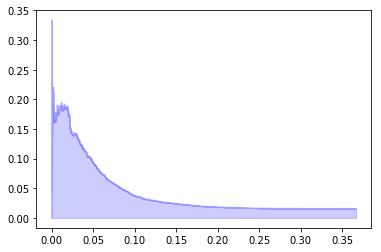

In [12]:
NetREXp_prec, NetREXp_rec = ComputePR(gold, predicted)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(NetREXp_rec, NetREXp_prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(NetREXp_rec, NetREXp_prec, alpha=0.2, color='b', **step_kwargs)

In [13]:
#import inferred Flynet network for comparison

genieKO = pd.read_table('../../s2cell-prior/data/yeast_networks/inferred/GENIE3.KO.txt', header=None, names=['regulator','gene', 'weight'])
merlinNV = pd.read_table('../../s2cell-prior/data/yeast_networks/inferred/MERLIN.NatVar.txt', header=None, names=['regulator','gene', 'weight'])

In [14]:
genieKO = genieKO.set_index(['gene','regulator']).unstack().fillna(value=0)

#remove names
genieKO.columns = genieKO.columns.get_level_values(1)
genieKO.index.name = None
genieKO.columns.name = None

genieKO.head()

,YAL011W,YAL021C,YAL043C,YAL051W,YAR007C,YBL002W,YBL005W,YBL008W,YBL021C,YBL023C,...,YPR068C,YPR072W,YPR086W,YPR104C,YPR129W,YPR133C,YPR175W,YPR193C,YPR196W,YPR199C
Q0085,0.000000,0.000000,0.001712,0.001763,0.000000,0.000000,0.000000,0.001912,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.00000,0.001749,0.0,0.000000,0.001361,0.0
YAL001C,0.003726,0.000000,0.000000,0.004298,0.001328,0.000000,0.000000,0.002517,0.000000,0.001207,...,0.0,0.001602,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0
YAL002W,0.000000,0.000000,0.000000,0.002055,0.002562,0.000000,0.000000,0.001302,0.002564,0.000000,...,0.0,0.003988,0.001564,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0
YAL003W,0.000000,0.000000,0.000000,0.000000,0.009347,0.008212,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.003245,0.0,0.00189,0.000000,0.0,0.001592,0.000000,0.0
YAL004W,0.008103,0.006635,0.001802,0.001499,0.003190,0.000000,0.002717,0.000000,0.001467,0.002602,...,0.0,0.000000,0.001174,0.0,0.00000,0.000000,0.0,0.001903,0.000000,0.0


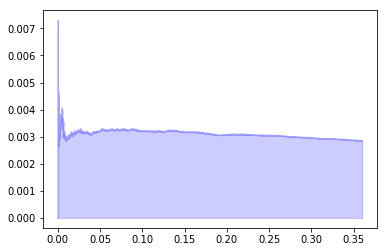

In [15]:
#same code used by Yijie above 
Genie3_prec, Genie3_rec = ComputePR(gold, genieKO)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(Genie3_rec, Genie3_prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(Genie3_rec, Genie3_prec, alpha=0.2, color='b', **step_kwargs)

In [16]:
merlinNV = merlinNV.set_index(['gene','regulator']).unstack().fillna(value=0)

#remove names
merlinNV.columns = merlinNV.columns.get_level_values(1)
merlinNV.index.name = None
merlinNV.columns.name = None

merlinNV.head()

,YAL011W,YAL021C,YAL043C,YAL051W,YAR007C,YBL002W,YBL005W,YBL008W,YBL021C,YBL023C,...,YPR068C,YPR072W,YPR086W,YPR104C,YPR129W,YPR133C,YPR175W,YPR193C,YPR196W,YPR199C
YAL001C,0.08,0.00,0.01,0.00,0.71,0.00,0.02,0.06,0.02,0.00,...,0.00,0.00,0.00,0.02,0.02,0.02,0.00,0.00,0.08,0.00
YAL002W,0.00,0.01,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,...,0.01,0.02,0.09,0.01,0.00,0.64,0.00,0.00,0.00,0.02
YAL003W,0.00,0.00,0.01,0.01,0.06,0.00,0.10,0.04,0.01,0.02,...,0.01,0.00,0.01,0.01,0.00,0.02,0.01,0.00,0.05,0.00
YAL005C,0.02,0.00,0.01,0.02,0.10,0.00,0.00,0.01,0.00,0.00,...,0.01,0.00,0.00,0.02,0.04,0.00,0.00,0.01,0.00,0.00
YAL007C,0.01,0.00,0.02,0.00,0.46,0.18,0.03,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


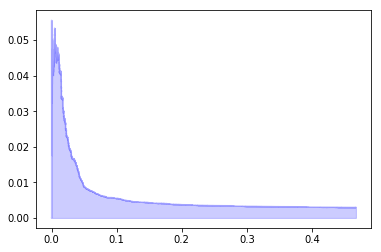

In [17]:
#same code used by Yijie above 

Merlin_prec, Merlin_rec = ComputePR(gold, merlinNV)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(Merlin_rec, Merlin_prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(Merlin_rec, Merlin_prec, alpha=0.2, color='b', **step_kwargs)

In [18]:
#import another
infStress = pd.read_table('../../s2cell-prior/data/yeast_networks/inferred/Inferelator.Stress.txt', header=None, names=['regulator','gene', 'weight'])

infStress = infStress.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
infStress.columns = infStress.columns.get_level_values(1)
infStress.index.name = None
infStress.columns.name = None

infStress.head()

,YAL011W,YAL021C,YAL043C,YAL051W,YAR007C,YBL002W,YBL005W,YBL008W,YBL021C,YBL023C,...,YPR068C,YPR072W,YPR086W,YPR104C,YPR129W,YPR133C,YPR175W,YPR193C,YPR196W,YPR199C
YAL001C,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
YAL002W,0.000000,0.0,0.0,0.0,0.000000,0.0,0.387937,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
YAL003W,0.000000,0.0,0.0,0.0,0.048069,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
YAL004W,0.048857,0.0,0.0,0.0,0.000000,0.0,0.000000,0.049269,0.0,0.0,...,0.0,0.0,0.0,0.0,0.04902,0.0,0.0,0.0,0.0,0.0
YAL005C,0.000000,0.0,0.0,0.0,0.000000,0.0,0.243126,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


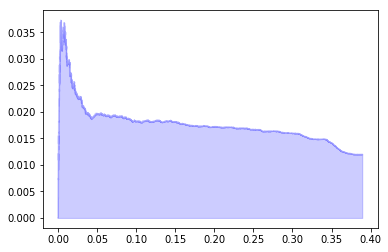

In [19]:
#same code used by Yijie above 

Inf_prec, Inf_rec = ComputePR(gold, infStress)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(Inf_rec, Inf_prec, color='b', alpha=0.2, where='post')
plt.fill_between(Inf_rec, Inf_prec, alpha=0.2, color='b', **step_kwargs)

In [20]:
#chip PRIOR

chip = pd.read_table('../../s2cell-prior/data/yeast_networks/priors/ChIP_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])

chip = chip.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
chip.columns = chip.columns.get_level_values(1)
chip.index.name = None
chip.columns.name = None

chip.head()

,MATA1,TBP,YAL011W,YAL021C,YAL043C,YAL051W,YBL002W,YBL005W,YBL008W,YBL021C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL001C,0.0,0.295455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.529278,0.0,0.000000,0.0,0.0
YAL002W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.335520,0.0,0.0,0.552461,0.0,0.000000,0.0,0.914234,0.0,0.0
YAL003W,0.0,0.000000,0.0,0.309524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.981256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL004W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL005C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794283,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [21]:
np.amax(chip.values)

1.98908

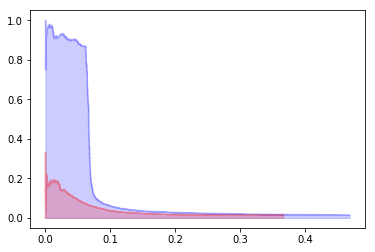

In [22]:
#same code used by Yijie above 

chip_prec, chip_rec = ComputePR(gold, chip)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(chip_rec, chip_prec, color='b', alpha=0.2, where='post')
plt.fill_between(chip_rec, chip_prec, alpha=0.2, color='b', **step_kwargs)
plt.step(NetREXp_rec, NetREXp_prec, color='r', alpha=0.2,
         where='post')
plt.fill_between(NetREXp_rec, NetREXp_prec, alpha=0.2, color='r', **step_kwargs)

In [23]:
print(np.count_nonzero(chip.values))
print(np.count_nonzero(predicted.values))

245784
199640


In [24]:
#import another
merlinP_NV = pd.read_table('../../s2cell-prior/data/yeast_networks/inferred/MERLIN_motif.NatVar.txt', header=None, names=['regulator','gene', 'weight'])

merlinP_NV = merlinP_NV.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
merlinP_NV.columns = merlinP_NV.columns.get_level_values(1)
merlinP_NV.index.name = None
merlinP_NV.columns.name = None

merlinP_NV.head()


,YAL011W,YAL021C,YAL043C,YAL051W,YAR007C,YBL002W,YBL005W,YBL008W,YBL021C,YBL023C,...,YPR068C,YPR072W,YPR086W,YPR104C,YPR129W,YPR133C,YPR175W,YPR193C,YPR196W,YPR199C
YAL001C,0.09,0.00,0.01,0.01,0.62,0.00,0.00,0.01,0.0,0.01,...,0.01,0.00,0.00,0.00,0.01,0.01,0.0,0.00,0.04,0.02
YAL002W,0.00,0.02,0.00,0.00,0.08,0.00,0.37,0.00,0.0,0.00,...,0.00,0.02,0.10,0.01,0.01,0.64,0.0,0.00,0.00,0.00
YAL003W,0.00,0.03,0.00,0.00,0.09,0.00,0.12,0.02,0.0,0.02,...,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.01,0.02,0.00
YAL005C,0.03,0.00,0.00,0.03,0.09,0.00,0.19,0.02,0.0,0.00,...,0.03,0.00,0.00,0.01,0.02,0.00,0.0,0.01,0.00,0.00
YAL007C,0.00,0.00,0.00,0.09,0.32,0.13,0.01,0.00,0.0,0.01,...,0.00,0.01,0.00,0.00,0.09,0.01,0.0,0.01,0.01,0.20


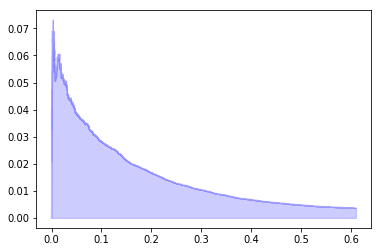

In [25]:
#same code used by Yijie above 

merlinP_prec, merlinP_rec = ComputePR(gold, merlinP_NV)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(merlinP_rec, merlinP_prec, color='b', alpha=0.2, where='post')
plt.fill_between(merlinP_rec, merlinP_prec, alpha=0.2, color='b', **step_kwargs)


In [26]:
#motif PRIOR

motif = pd.read_table('../../s2cell-prior/data/yeast_networks/priors/Motif_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])

motif = motif.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
motif.columns = motif.columns.get_level_values(1)
motif.index.name = None
motif.columns.name = None

motif.head()

,MAL63,MATA1-MATALPHA2-DIMER,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL051W,YBL005W,YBL054W,YBL103C,YBR033W,...,YPR013C,YPR015C,YPR022C,YPR052C,YPR054W,YPR065W,YPR086W,YPR104C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977


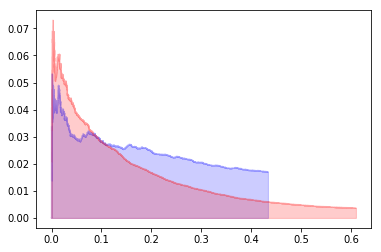

In [27]:
#same code used by Yijie above 

motif_prec, motif_rec = ComputePR(gold, motif)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(motif_rec, motif_prec, color='b', alpha=0.2, where='post')
plt.fill_between(motif_rec, motif_prec, alpha=0.2, color='b', **step_kwargs)
plt.step(merlinP_rec, merlinP_prec, color='r', alpha=0.2, where='post')
plt.fill_between(merlinP_rec, merlinP_prec, alpha=0.2, color='r', **step_kwargs)

In [31]:
c_cutoff_netrex = pd.read_table('yeast_netrex_c_cutoff_predicted_network', index_col=0)

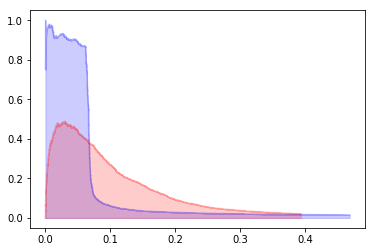

In [34]:
c_NetREXp_prec, c_NetREXp_rec = ComputePR(gold, c_cutoff_netrex)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(chip_rec, chip_prec, color='b', alpha=0.2, where='post')
plt.fill_between(chip_rec, chip_prec, alpha=0.2, color='b', **step_kwargs)
plt.step(c_NetREXp_rec, c_NetREXp_prec, color='r', alpha=0.2,
         where='post')
plt.fill_between(c_NetREXp_rec, c_NetREXp_prec, alpha=0.2, color='r', **step_kwargs)